In [131]:
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 965 kB 1.6 MB/s            
     |████████████████████████████████| 61 kB 12.1 MB/s            
     |████████████████████████████████| 118 kB 65.7 MB/s            
     |████████████████████████████████| 58 kB 10.0 MB/s            
     |████████████████████████████████| 1.0 MB 78.1 MB/s            
     |████████████████████████████████| 1.0 MB 107.7 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's de

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torch import optim
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import preprocessing

import optuna
from optuna.trial import TrialState

import numpy as np
import pandas as pd

import random as rnd
import os
import math
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
from cairosvg import svg2png
from IPython import display

import utils.dataloader as dl
from utils.svg import SVG
import umap
import wandb

%matplotlib inline

In [2]:
#!g1.4
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 32
FONT_SIZE = len(dl.GLYPH_FILTER)
# fonts_number = 100
# fonts_number = 8000
fonts_number = None

print(f'Device: {device}')

Device: cuda


## Загрузка данных

In [3]:
dataset_train = dl.FontsDataset(test=False, download=True)
dataset_test = dl.FontsDataset(test=True)

Grouping by font: 100%|█████████████████████████████████████████████████████| 127677/127677 [00:04<00:00, 28544.03it/s]


In [4]:
train_dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0, collate_fn=dl.collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0, collate_fn=dl.collate_fn)

C, aamazingmother


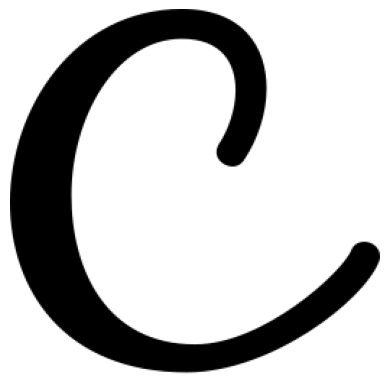

In [5]:
#!g1.4
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

def show_sampled(x: np.ndarray, axis=None):
    if axis is None:
        axis = plt
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    axis.axis('off')
    axis.imshow(img)
    
imgs, labels, font_names = dataset_test[12*3]
print(labels[0], font_names[0], sep=', ')
save_sampled(imgs[0], 'test_print.svg')
show_sampled(imgs[0])

## Определение рисователя прогресса

In [6]:
#!g1.4
class Progresser:
    def __init__(self, _train_dataloader, split_num=4, xlabel='time (epochs)', ylabel='loss'):
        self.epoch = 0
        self.ox = {}
        self.oy = {}
        self.color = {}
        self.interval = len(_train_dataloader) // split_num
        self.xlabel = xlabel
        self.ylabel = ylabel

    def show_progress(self, t, epochs, save_to=None, info: Optional[dict] = None, clear=True):
        if clear:
            display.clear_output(wait=True)
        fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
        fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)

        for ax, msg in zip(axs, ('', 'last 50%')):
            title = f'loss {msg}'
            if info is not None:
                title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
            ax.set_title(title)
            ax.set_xlabel('time (epochs)')
            ax.set_ylabel('loss')

        for label in self.oy.keys():
            ox, oy, c = self.ox[label], self.oy[label], self.color[label]
            last = str(oy[-1]) if len(oy) > 0 else ''
            axs[0].plot(ox, oy, c=c, lw=3, label=f'{label}: {last}')
            axs[1].plot(
                ox[- len(ox) // 2:], oy[- len(oy) // 2:], 
                c=c, lw=3, label=f'{label}: {last}'
            )

        axs[0].legend()
        axs[1].legend()
        if save_to is None:
            plt.show() 
        else:
            if not isinstance(save_to, Path):
                save_to = Path(save_to)
            save_to.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(str(save_to))
            plt.close()
        plt.close()
    
    def add_train(self, ts, loss):
        self.add(ts, loss, 'train', 'darkblue')

    def add_test(self, ts, loss):
        self.add(ts, loss, 'test', 'green')
        
    def add(self, x, y, label, color=None):
        self.color[label] = color
        self.ox.setdefault(label, []).append(x)
        self.oy.setdefault(label, []).append(y)
        
    def reset(self):
        self.ox = {}
        self.oy = {}
        self.epoch = 0

## Дискриминатор

In [450]:
#!g1.4
class Block(nn.Module):
    def __init__(self, f_in, f_out, activation=nn.SiLU):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            activation(),
        )

    def forward(self, x):
        return self.layer(x)

    
class Discriminator(nn.Module):
    """0 for real, 1 for generated"""
    def __init__(self, params):
        super().__init__()
        assert params[-1] == 1
        self.name = f'{self.__class__.__name__}_{params}'
        
        self.layers = nn.Sequential(
            *[Block(params[i], params[i + 1]) for i in range(len(params) - 2)],
            Block(params[-2], params[-1], activation=nn.Sigmoid),
        )
        self._loss_fn = nn.BCELoss(reduction='mean')
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)
        
    def loss(self, x_hat, x):
        return self._loss_fn(x_hat, x)
    
    def mysave(self):
        save_folder = Path('models') / self.__class__.__name__ / self.name
        save_folder.mkdir(parents=True, exist_ok=True)
        torch.save(self.state_dict(), save_folder / 'ckpt.pt')

    def myload(self):
        path = Path('models') / self.__class__.__name__ / self.name / 'ckpt.pt'
        if path.exists():
            self.load_state_dict(torch.load(path))
            return True
        return False
    
    def train_fn(self, x_real, x_fake, d_optim):
        fake_and_real_input = torch.cat((x_real, x_fake))
        d_labels_fake = torch.ones(len(x_fake), 1).to(device)
        d_labels_real = torch.zeros(len(x_real), 1).to(device)
        d_out = self(fake_and_real_input)
        d_out_fake = d_out[:len(d_out) // 2]
        d_out_real = d_out[len(d_out) // 2:]
        d_loss_fake = self.loss(d_out_fake, d_labels_fake)
        d_loss_real = self.loss(d_out_real, d_labels_real)
        d_loss = d_loss_fake + d_loss_real
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()
        return d_loss, d_loss_fake, d_loss_real

    def optimize(self, x, steps=100, lr=3e-4):
        x.requires_grad = True
        optimizer = optim.Adam((x,), lr=lr)
        for _ in tqdm(range(steps)):
            out = self(x).mean()
            print(out)
            optimizer.zero_grad()
            out.backward()
            optimizer.step()
        return x

## Автоэнкодер

In [451]:
#!g1.4
class AE(nn.Module):
    activation = nn.Tanh

    def __init__(self, params, line_size, discriminator=None, d_optim=None):
        super().__init__()
        self.name = f'{self.__class__.__name__}_{params}'

        self.line_size = line_size
        
        encoder_params = params[:]        
        decoder_params = params[::-1]

        self.encoder = []
        for i in range(len(encoder_params) - 2):
            self.encoder.append(Block(encoder_params[i], encoder_params[i + 1], activation=nn.Tanh))
        self.encoder.append(Block(encoder_params[-2], encoder_params[-1], activation=nn.Tanh))

        self.decoder = []
        for i in range(len(decoder_params) - 2):
            self.decoder.append(Block(decoder_params[i], decoder_params[i + 1], activation=nn.Tanh))
        self.decoder.append(Block(decoder_params[-2], decoder_params[-1], activation=nn.ReLU))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        # idk how to extract field from module submodules
        self.discriminator = [discriminator, d_optim]
        self.last_d_loss = 1
        
    def encode(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        return x

    def decode(self, z):
        z = self.decoder(z)
        z = z.view(z.shape[0], -1, self.line_size)
        return z
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
        
    def loss(self, x_hat, x):
        mse = F.mse_loss(x_hat, x, reduction='sum')
        return mse / x.shape[0]
    
    def style_loss(self, x, font_names):
        result = torch.tensor(5, dtype=torch.float32).to(device)
        used = 0
        for font in font_names:
            ln = len(font)
            used += ln

            x_font = x[used:used + ln]
            
            mean = x_font.mean(axis=0)
            diff = (x_font - mean) ** 2
            result += diff.sum()
        return result / len(x)
    
    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        discriminator, d_optim = self.discriminator
        self.train()
        num_batches = len(dataloader)
        for batch, (images, _, font_names) in enumerate(dataloader):
            # bs x ? x 32 x 11
            images = np.concatenate(images)
            images = torch.Tensor(images).to(device)
               
            z = self.encode(images)
            output = self.decode(z)
            # style_loss = self.style_loss(z, font_names)
            mse_loss = self.loss(output, images)
            loss = mse_loss
            # if self.last_d_loss < 1:
            d_out_ae = discriminator(output).mean() * max((0.7 - self.last_d_loss / 2), 0) * mse_loss.item()
            loss = mse_loss + d_out_ae

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Обучение дискриминатора на тех же данных
            d_loss, d_loss_fake, d_loss_real = discriminator.train_fn(output.detach(), images, d_optim)
            self.last_d_loss = d_loss.item()
            
            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                progresser.add(t, mse_loss.item(), 'mse_test_ae', 'purple')
                progresser.add(t, d_loss_fake.item(), 'discr_fake', 'orange')
                progresser.add(t, d_loss_real.item(), 'discr_real', 'yellow')
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()            
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        discriminator, _ = self.discriminator
        print(next(iter(self.parameters())))
        
        tmp_test_loss = []
        for images, _, _ in dataloader:
            images = np.concatenate(images)
            images = torch.Tensor(images).to(device)
            
            result = self(images)
            loss = self.loss(result, images)
            # loss += discriminator(result).sum()

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)
            
    def mysave(self):
        save_folder = Path('models') / self.__class__.__name__ / self.name
        save_folder.mkdir(parents=True, exist_ok=True)
        torch.save(self.state_dict(), save_folder / 'ckpt.pt')
        self.discriminator[0].mysave()

    def myload(self):
        path = Path('models') / self.__class__.__name__ / self.name / 'ckpt.pt'
        if path.exists():
            self.load_state_dict(torch.load(path))
            return True
        return False

## Вспомогательные функции

In [452]:
#!g1.4
def to_numpy(d):
    return d.cpu().detach().numpy()


ONE_HOT_LEN = FONT_SIZE
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER,
        range(0, ONE_HOT_LEN),
    )
}


def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()


def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)


def run(model, train_dl, test_dl, optimizer, scheduler, epochs, params, _epoch=0, trial=None, save=True):
    class_name = model.__class__.__name__

    save_folder = Path('models') / model.__class__.__name__ / model.name
    loss_img_path = str(save_folder / '_loss.png') if save else None
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    max_epoch = progresser.epoch + epochs

    if trial is None:
        pbar = trange(progresser.epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(progresser.epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, train_dl, optimizer, scheduler, pbar, show=True)
        model.test_fn(_epoch + 1, max_epoch, test_dl, show=True)
        
        if save:
            model.mysave()
        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            progresser.epoch = _epoch + 1
        progresser.show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})

def setup_ae(params, d_params, lr, weight_decay=2e-5, step_size=1, step_gamma=0.95, line_size=None):
    if line_size is None:
        raise Exception('line_size should be provided')

    if d_params is None:
        d_params = np.repeat([p for p in params], 2)[1:].tolist()
        d_params[-1] = 1
    discriminator = Discriminator(d_params).to(device)
    # for p in discriminator.parameters():
        # nn.init.normal_(p, mean=0, std=1e-6)
    d_optim = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay)
    
    model = AE(params, line_size, discriminator, d_optim).to(device)
    # for p in model.parameters():
        # nn.init.normal_(p, mean=0, std=1e-6)
        
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)

    return model, optimizer, scheduler


## Поиск конфигурации модели для кодирования глифов

Запуск дашборда `optuna-dashboard --server wsgiref sqlite:///db_full.sqlite3`
http://127.0.0.1:8080/

In [ ]:
#!g1.4
def run_for_search(trial):
    lr = trial.suggest_float('lr', 7e-6, 8e-4, log=True)
    p0 = trial.suggest_int('p0', 1600, 4500)
    params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, p0]
    latent_size = 256

    for i in range(1, 5):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    # step_gamma = trial.suggest_float('step_gamma', 0.94, 1)
    
    model, optimizer, scheduler = setup_ae(
        params=params,
        lr=lr,
        weight_decay=3e-6,
        line_size=SVG.ENCODE_WIDTH,
        step_gamma=0.95,
    )
    run(
        model=model, 
        train_dl=train_dataloader,
        test_dl=test_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=15,
        params=params,
        run_name='temp',
        trial=trial,
    )
    return progresser.test_loss[-1]


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db_ae.sqlite3",
    study_name="ae_lr,6layers,15epoch",
    load_if_exists=True,
)

study.optimize(run_for_search, n_trials=14, show_progress_bar=True)

## Создание и запуск AE

AE had been loaded from file
Discriminator has been loaded from file


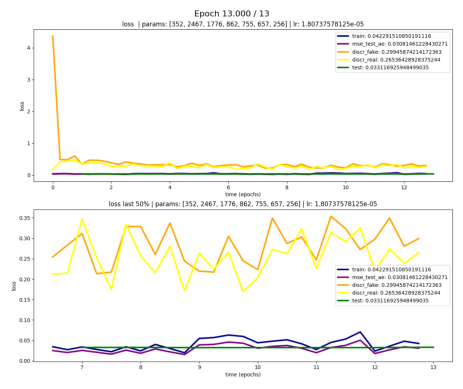

In [453]:
#!g1.4
force = False
GLIPH_WIDTH = 256
params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 2467, 1776, 862, 755, 657, GLIPH_WIDTH]
d_params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 2467, 2000, 1776, 1200, 1024, 512, 256, 128, 64, 32, 16, 8, 1]
# lr = 3e-5
lr = 2e-5

model_ae, optimizer, scheduler = setup_ae(
    params=params,
    d_params=d_params,
    lr=lr,
    weight_decay=4e-6,
    line_size=SVG.ENCODE_WIDTH,
    step_size=3,
    step_gamma=0.975,
)
progresser = Progresser(train_dataloader)
if not force and model_ae.myload():
    print('AE had been loaded from file')
    save_folder = Path('models') / model_ae.__class__.__name__ / model_ae.name
    img = mpimg.imread(Path(save_folder) / '_loss.png')
    plt.axis('off')
    plt.imshow(img)
else:
    print('Created new AE')
if not force and model_ae.discriminator[0].myload():
    print('Discriminator has been loaded from file')
else:
    print('Created new Discriminator')

In [364]:
model_ae.state_dict()['encoder.0.layer.0.weight']

tensor([[-7.1002e-41,  1.2411e-02,  1.3769e-39,  ...,  8.0162e-40,
         -4.8932e-40, -7.7853e-40],
        [ 1.3823e-39,  2.0721e-02, -2.4313e-40,  ...,  7.3325e-40,
         -1.3796e-39, -1.3804e-39],
        [-7.5809e-41, -2.5767e-02,  7.4644e-40,  ..., -1.5478e-39,
         -7.2364e-41,  1.1799e-39],
        ...,
        [-1.5341e-39, -1.5515e-02, -9.8517e-40,  ...,  4.9165e-40,
          4.1933e-40, -7.7021e-40],
        [ 3.5399e-40, -9.1268e-03,  3.9869e-40,  ..., -1.5654e-39,
          3.1010e-40,  6.2229e-41],
        [ 2.9316e-40,  3.7321e-02, -4.8487e-40,  ...,  8.2842e-40,
         -8.9217e-40,  3.6070e-40]], device='cuda:0')

In [344]:
model_ae.state_dict()['encoder.0.layer.0.weight']

tensor([[-7.1002e-41,  1.2411e-02,  1.3769e-39,  ...,  8.0162e-40,
         -4.8932e-40, -7.7853e-40],
        [ 1.3823e-39,  2.0721e-02, -2.4313e-40,  ...,  7.3325e-40,
         -1.3796e-39, -1.3804e-39],
        [-7.5809e-41, -2.5767e-02,  7.4644e-40,  ..., -1.5478e-39,
         -7.2364e-41,  1.1799e-39],
        ...,
        [-1.5341e-39, -1.5515e-02, -9.8517e-40,  ...,  4.9165e-40,
          4.1933e-40, -7.7021e-40],
        [ 3.5399e-40, -9.1268e-03,  3.9869e-40,  ..., -1.5654e-39,
          3.1010e-40,  6.2229e-41],
        [ 2.9316e-40,  3.7321e-02, -4.8487e-40,  ...,  8.2842e-40,
         -8.9217e-40,  3.6070e-40]], device='cuda:0')

In [210]:
wandb.init(project='debug_discr')
wandb.watch(model_ae.discriminator[0], log='all')

[]

In [389]:
#!g1.4
run(
    model=model_ae,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=1,
    params=params,
)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:18<00:00, 78.75s/it]


In [223]:
wandb.finish()

 18%|██████████████▉                                                                    | 9/50 [00:00<00:00, 47.40it/s]

tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4455, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4340, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4198, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3975, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3683, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3113, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|█████████████████████████████████████████████████████████████▌                   | 38/50 [00:00<00:00, 120.14it/s]

tensor(0.3082, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3077, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3075, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3042, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3004, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2955, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2901, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2849, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2804, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2768, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2740, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2681, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2668, device='cuda:0',

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 109.77it/s]
C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_33048\4209477185.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, imgs_num, i + 1)


tensor(0.2615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2588, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2537, device='cuda:0', grad_fn=<MeanBackward0>)


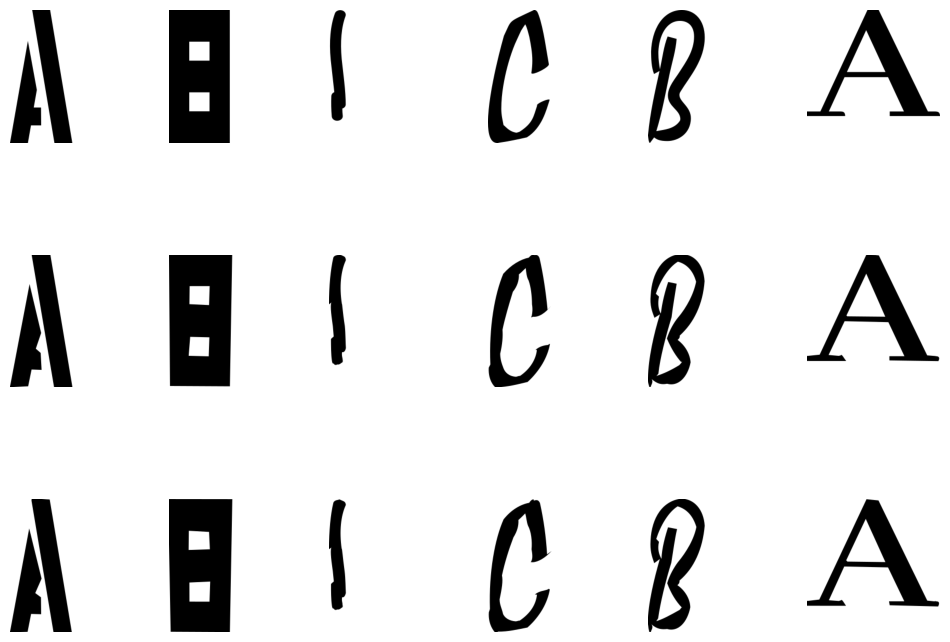

In [455]:
#!g1.4
imgs_num = 6
plt.figure(figsize=(2 * imgs_num, 9))
plt.axis('off')

pre_samples, _, _ = dataset_train[:(100)*imgs_num: 100]

samples = []
for font in pre_samples:
    samples.append(font[0].reshape(1, SVG.ENCODE_HEIGHT, SVG.ENCODE_WIDTH))
samples = np.concatenate(samples)
    
model_ae.eval()
processed_samples = to_numpy(model_ae(torch.Tensor(samples).to(device)))
refined_samples = to_numpy(
    model_ae.discriminator[0].optimize(
        torch.Tensor(processed_samples).to(device),
        steps=50,
        lr=1e-4,
    )
)

for i in range(imgs_num):
    plt.subplot(3, imgs_num, i + 1)
    plt.axis('off')
    show_sampled(samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num + i + 1)
    plt.axis('off')
    show_sampled(processed_samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num * 2 + i + 1)
    plt.axis('off')
    show_sampled(refined_samples[i])
plt.show()

In [427]:
before = torch.Tensor(processed_samples).to(device)
after = model_ae.discriminator[0](before)
before2 = torch.Tensor(samples).to(device)
after2 = model_ae.discriminator[0](before2)

In [428]:
print(after)

tensor([[0.5011],
        [0.9942],
        [0.3386],
        [0.0879],
        [0.0913],
        [0.9966]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [429]:
print(after2)

tensor([[0.5004],
        [0.0223],
        [0.0115],
        [0.0405],
        [0.2056],
        [0.2095]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [430]:
model_ae.discriminator[0].optimize(before)

tensor([[[0.0000, 0.9998, 0.0000,  ..., 0.0000, 0.0000, 0.9978],
         [0.0000, 0.0000, 1.0037,  ..., 0.0000, 0.1471, 0.2260],
         [0.0000, 0.0000, 1.0038,  ..., 0.0000, 0.2341, 0.5939],
         ...,
         [0.9995, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9985, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9997, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 1.0005, 0.0000,  ..., 0.0000, 0.0000, 0.0047],
         [0.0000, 0.0000, 0.9989,  ..., 0.0000, 0.4754, 0.0000],
         [0.0000, 0.0000, 1.0028,  ..., 0.0000, 0.4580, 0.9949],
         ...,
         [0.9994, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0004, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0005, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.9999, 0.0000,  ..., 0.0000, 0.0000, 0.3783],
         [0.0000, 0.0000, 0.0000,  ..., 0.1177, 0.0325, 0.0269],
         [0.0000, 0.0000, 0.0000,  ..., 0.0092, 0.0733, 0.

In [376]:
#!g1.4
def decode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.decode(d)

def encode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.encode(d)

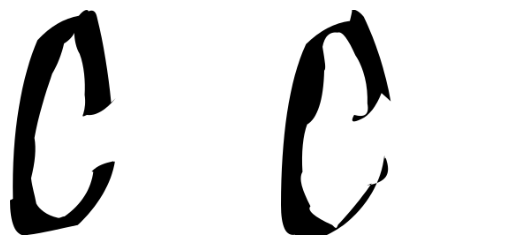

In [377]:
#!g1.4
sample = dataset_train[100 * 3][0][0]

sample = torch.Tensor(sample.reshape((1, -1))).to(device)

sp = encode_img(sample)

plt.subplot(1, 2, 1)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))

shift = torch.randn_like(sp) * 0.01

sp += shift

plt.subplot(1, 2, 2)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))
plt.show()

In [378]:
from ipywidgets import interact

In [379]:
img = dataset_test[69][0][0]

@interact(x=(-1,1,0.01), s=(0, 255))
def f(x=0, s=0):
    tmp = encode_img(torch.Tensor([img]).to(device))
    tmp[0][s] = x
    decoded = decode_img(tmp)
    show_sampled(to_numpy(decoded)[0])


interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), IntSlider(value=0…

## Дифузионная модель

In [135]:
%pip install --upgrade diffusers transformers accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [15]:
import diffusers
from diffusers import UNet2DModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

In [16]:
#!g1.4
IMG_SIZE = 16
EPOCHS = 200

dataset = ConcatDataset([dataset_train, dataset_test])
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=dl.collate_fn)

In [17]:
#!g1.4
name = '612_4_mse'
try:
    model = UNet2DModel.from_pretrained(f'models/DiffusionCond/{name}/unet')
    print('Loaded from pretrained')
except Exception as e:
    print(e)
    model = UNet2DModel(
        sample_size=IMG_SIZE,  # the target image resolution
        in_channels=1,  # the number of input channels, 3 for RGB images
        out_channels=1,  # the number of output channels
        layers_per_block=4,  # how many ResNet layers to use per UNet block
        block_out_channels=(64, 128, 256),  # the number of output channes for each UNet block
        down_block_types=( 
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D"  
        ),
        num_class_embeds=FONT_SIZE,
        class_embed_type='timestep',
    )
model.to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Loaded from pretrained
Num params:  23642881


UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel

In [18]:
#!g1.4
def make_grid(images, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    axes = axes.flatten()
    
    images = to_numpy(decode_img(images.reshape((-1, GLIPH_WIDTH))))
    for i, image in enumerate(images):
        show_sampled(image, axes[i])
    return fig, axes

def evaluate(epoch):
    torch.manual_seed(12)
    imgs = torch.randn((4, 1, IMG_SIZE, IMG_SIZE), device=device)
    labels = labels2num(['one', 'y', 'z', 'N']).to(device)
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            residual = model(imgs, t, labels).sample

        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    
    fig, axes = make_grid(imgs, rows=2, cols=2)

    # Save the images
    test_dir = Path(f'imgs/DiffusionCond/{name}')
    test_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(test_dir / f'{epoch:04d}.png')
    plt.close(fig)

In [19]:
#!g1.4
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(dataloader) * EPOCHS),
)
progresser = Progresser(dataloader)
try:
    noise_scheduler = DDPMScheduler.from_pretrained(f'models/DiffusionCond/{name}/scheduler')
    print('Noise sheduler loaded from pretrained')
except Exception as e:
    print(e)
    noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Noise sheduler loaded from pretrained


In [20]:
def loss_fn(x_hat, x):
    mse = F.mse_loss(x_hat, x, reduction='sum')
    return mse / x.shape[0]

In [21]:
#!g1.4
global_step = 0

In [22]:
#!g1.4
for epoch in range(progresser.epoch, progresser.epoch + EPOCHS):
    progress_bar = tqdm(total=len(dataloader), position=0, leave=True)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, (font_svgs, font_labels, font_names) in enumerate(dataloader):
        fonts_num = len(font_names)
        
        svgs_tensor = torch.Tensor(np.concatenate(font_svgs)).to(device)
            
        clean_images = encode_img(svgs_tensor).reshape((-1, 1, IMG_SIZE, IMG_SIZE))
        
        # Генерируем одинаковые параметры шума и шага для образцов внутри одного шрифта
        noise_per_font = [
            torch.randn((len(font_name), 1, IMG_SIZE, IMG_SIZE)).to(device)
            for font_name in font_names
        ]
        noise = torch.cat(noise_per_font)
        
        timesteps_per_font = [
            torch.randint(0, noise_scheduler.num_train_timesteps, (len(font_name),), device=device).long()
            for font_name in font_names
        ]
        timesteps = torch.cat(timesteps_per_font)
        
        # forward diffusion process
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Predict the noise residual
        labels = labels2num(np.concatenate(font_labels)).to(device)
        
        noisy_images = noisy_images.contiguous()
        timesteps = timesteps.contiguous()
        labels = labels.contiguous()
        
        noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
        loss = loss_fn(noise_pred, noise)
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1
        
        if step % 100 == 0 or step + 1 == len(dataloader):
            progresser.add_train(epoch + step / len(dataloader), loss.detach().item())
    progresser.show_progress(epoch, progresser.epoch + EPOCHS, save_to=f'imgs/DiffusionCond/_{name}.loss.png', clear=False)
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    evaluate(epoch)
    pipeline.save_pretrained(f'models/DiffusionCond/{name}')
    torch.save(model.state_dict(), f'models/DiffusionCond/{name}/ckpt.pt')

Epoch 155: 100%|███████████████████████████████| 4479/4479 [28:22<00:00,  2.63it/s, loss=0.111, lr=2.3e-5, step=698723]


KeyboardInterrupt: 

In [23]:
#!g1.4
evaluate(999)

## Визуализация генерации

In [24]:
#!g1.4
def sample(n=1, imgs = None, labels = None):
    if imgs is None:
        imgs = torch.randn((n, 1, IMG_SIZE, IMG_SIZE), device=device)
    if labels is None:
        labels = labels or np.random.choice(dl.GLYPH_FILTER, n)
    labels_num = labels2num(labels).to(device)
    
    for t in tqdm(noise_scheduler.timesteps, position=0, leave=True):
        with torch.no_grad():
            residual = model(imgs, t, labels_num).sample

        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    return imgs, labels

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.88it/s]


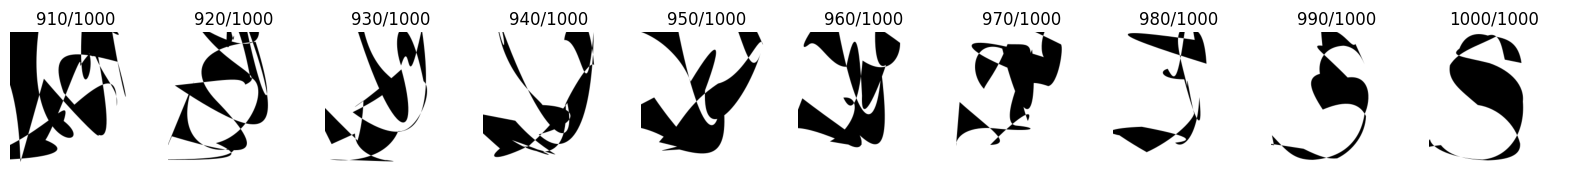

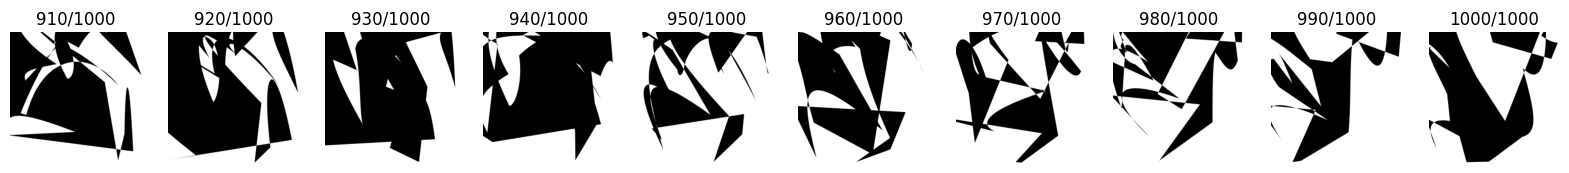

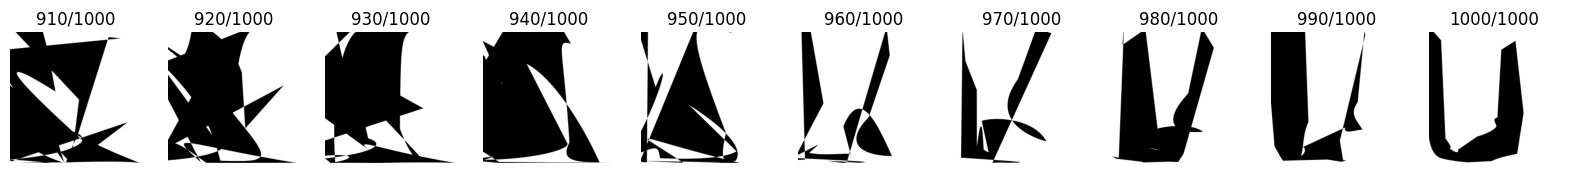

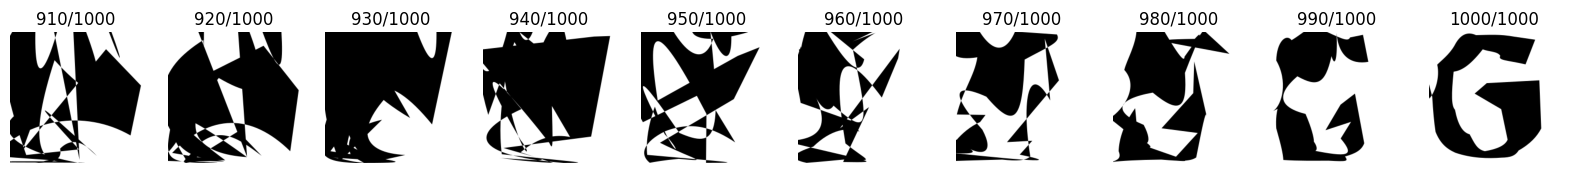

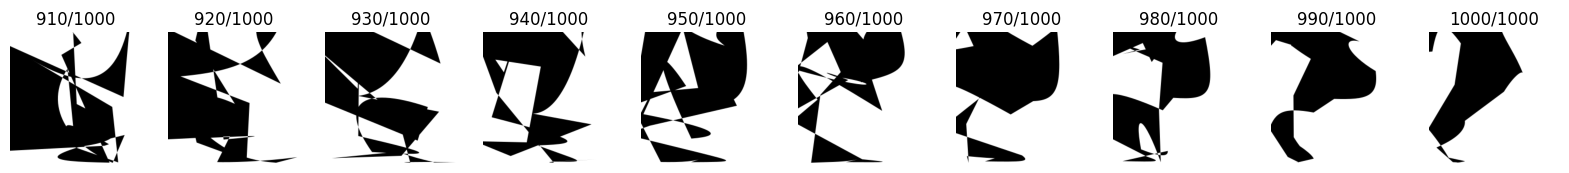

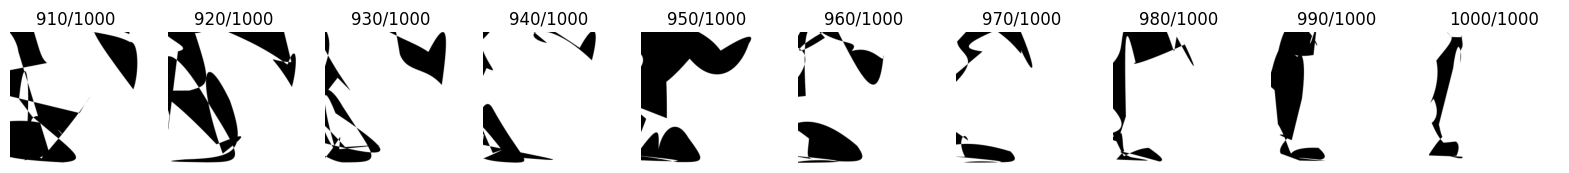

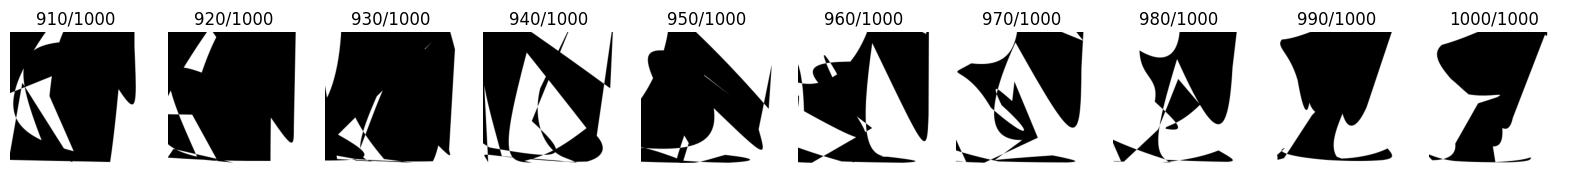

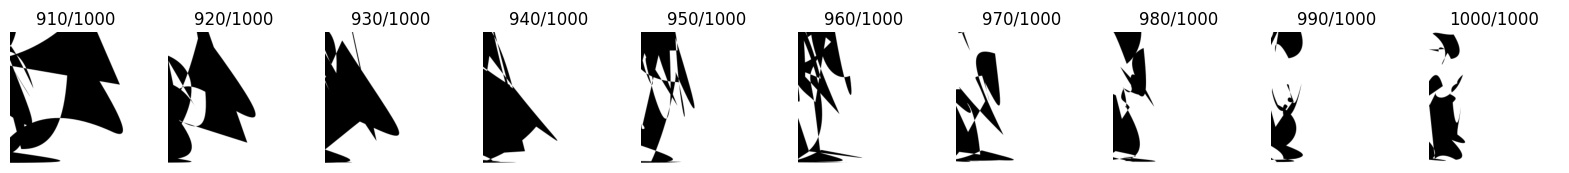

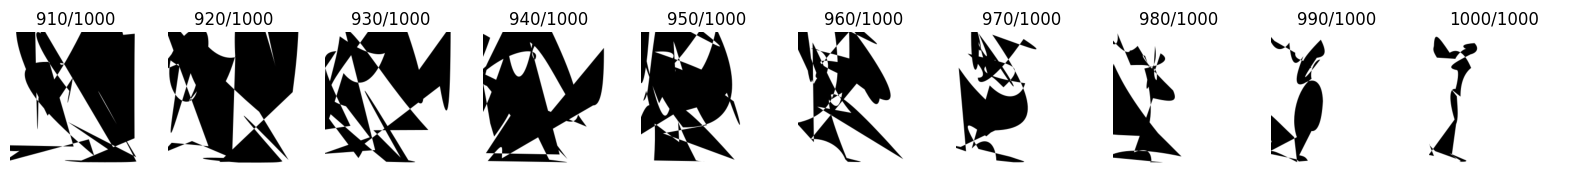

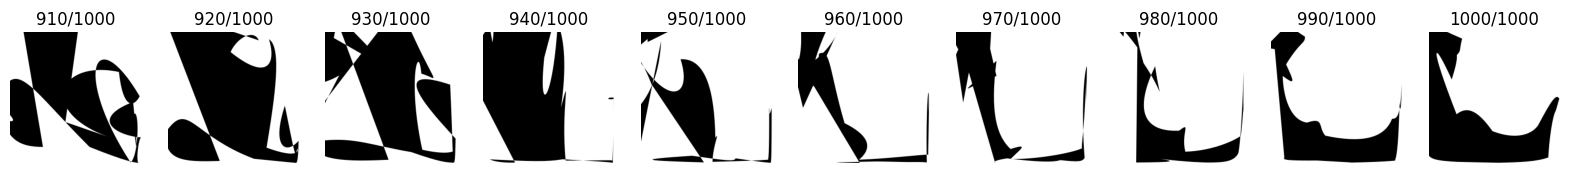

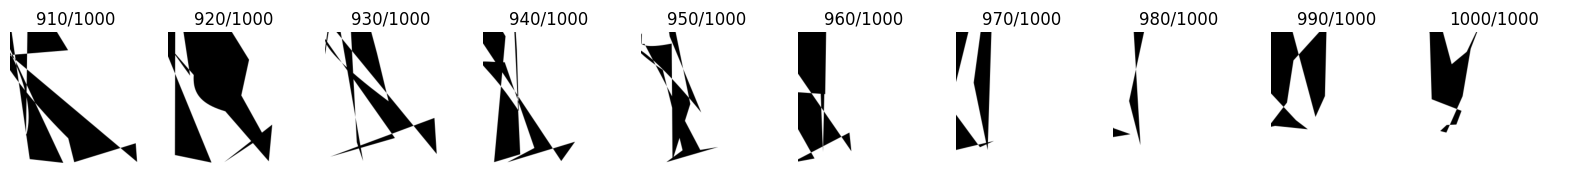

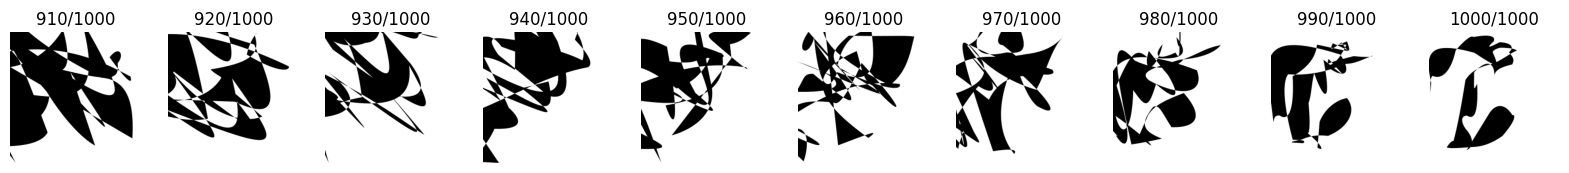

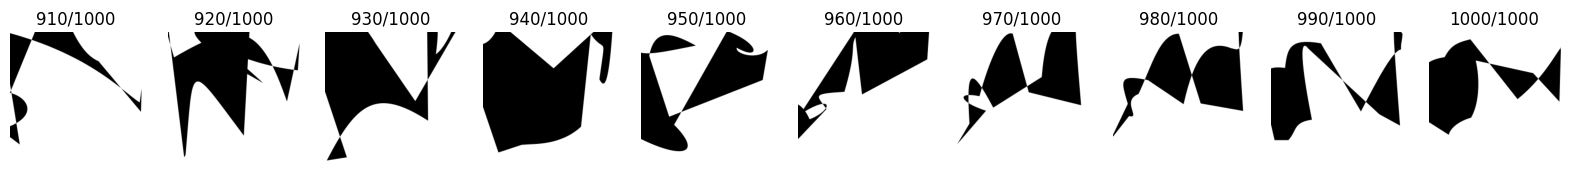

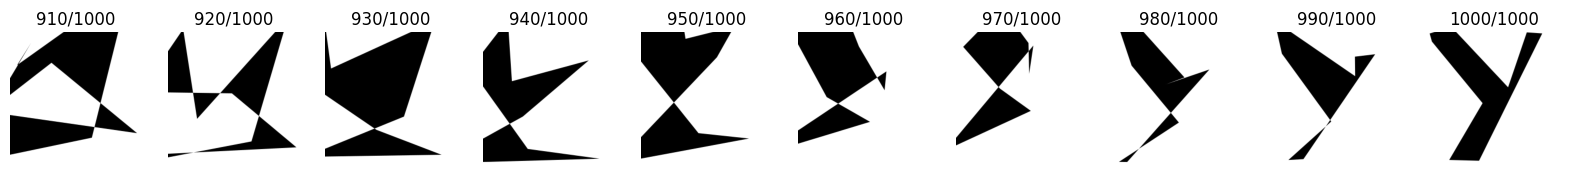

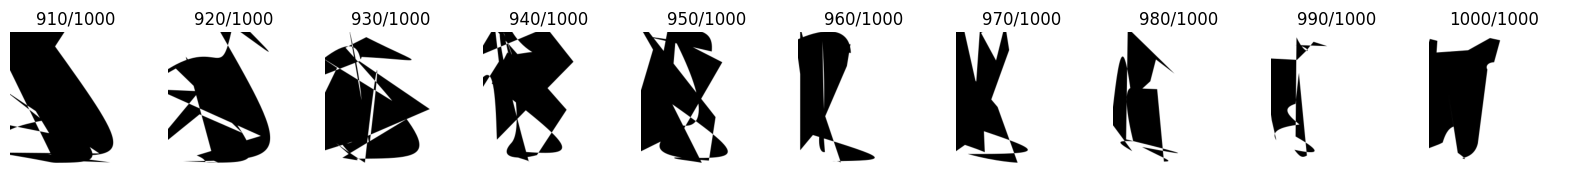

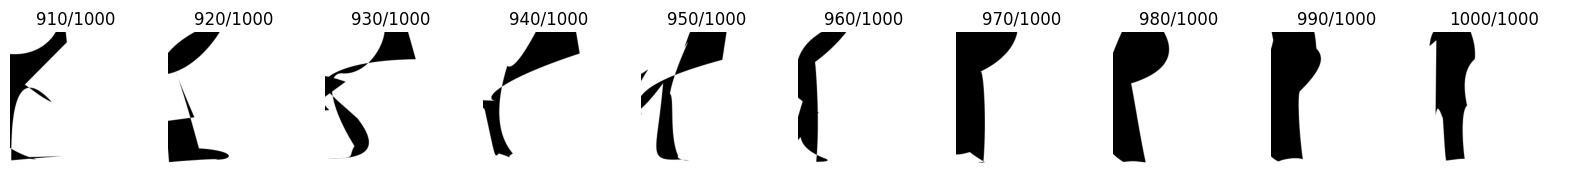

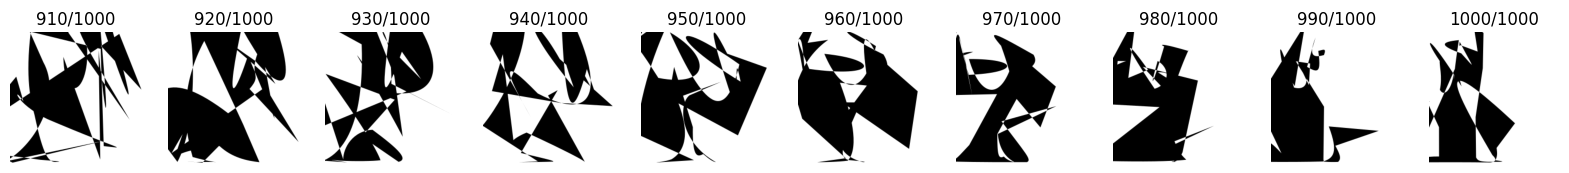

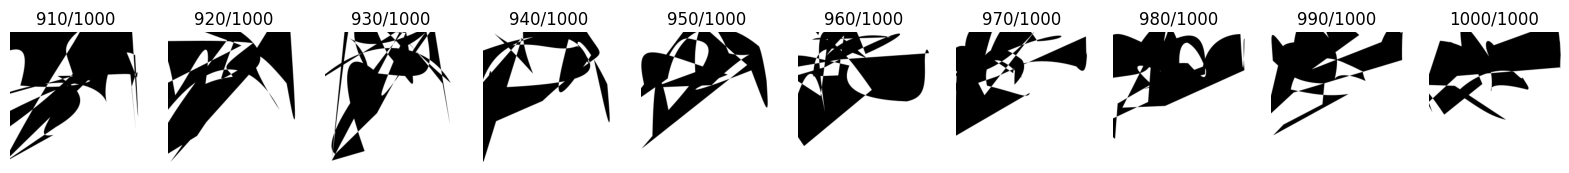

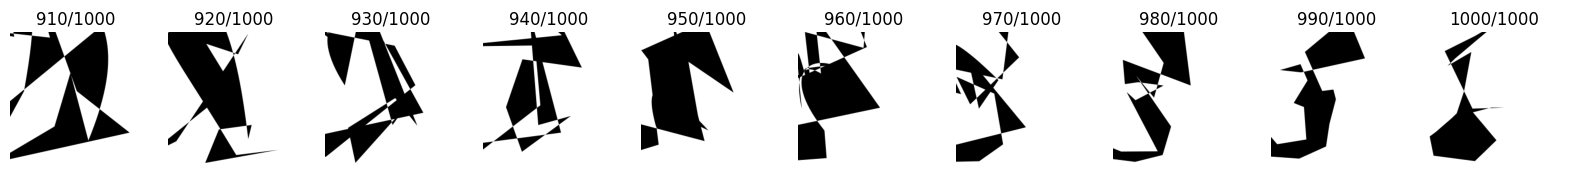

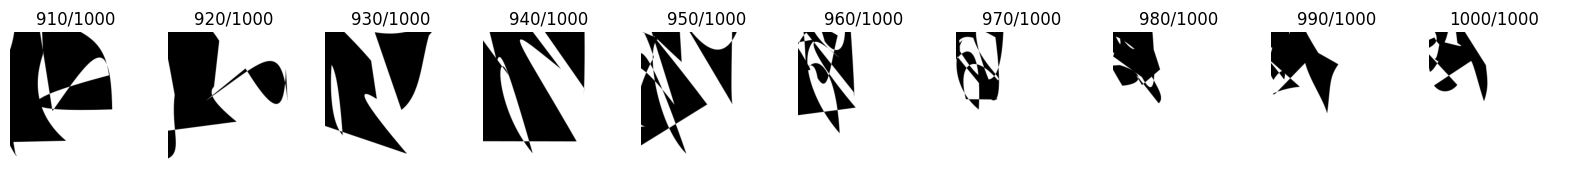

In [25]:
def show_sampling():
    n = 20
    imgs = torch.randn((n, 1, IMG_SIZE, IMG_SIZE), device=device)
    labels = np.random.choice(dl.GLYPH_FILTER, n)
    labels = labels2num(labels).to(device)
    
    result = [[] for i in range(n)]
    
    for i, t in enumerate(tqdm(noise_scheduler.timesteps, position=0, leave=True)):
        with torch.no_grad():
            residual = model(imgs, t, labels).sample

        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
        if (i + 1) > 900 and (i + 1) % 10 == 0:
            for j, img in enumerate(imgs):
                svg = to_numpy(decode_img(img.reshape(-1, IMG_SIZE*IMG_SIZE)))[0]
                result[j].append(svg)

    for i, row in enumerate(result):
        fig, axes = plt.subplots(1, len(row), figsize=(2*len(row), 2))

        for j, svg in enumerate(row):
            show_sampled(svg, axes[j])
            axes[j].title.set_text(f'{910 + j * 10}/1000')
        plt.show()
        plt.close(fig)

show_sampling()

## Генерация шрифта

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.10it/s]


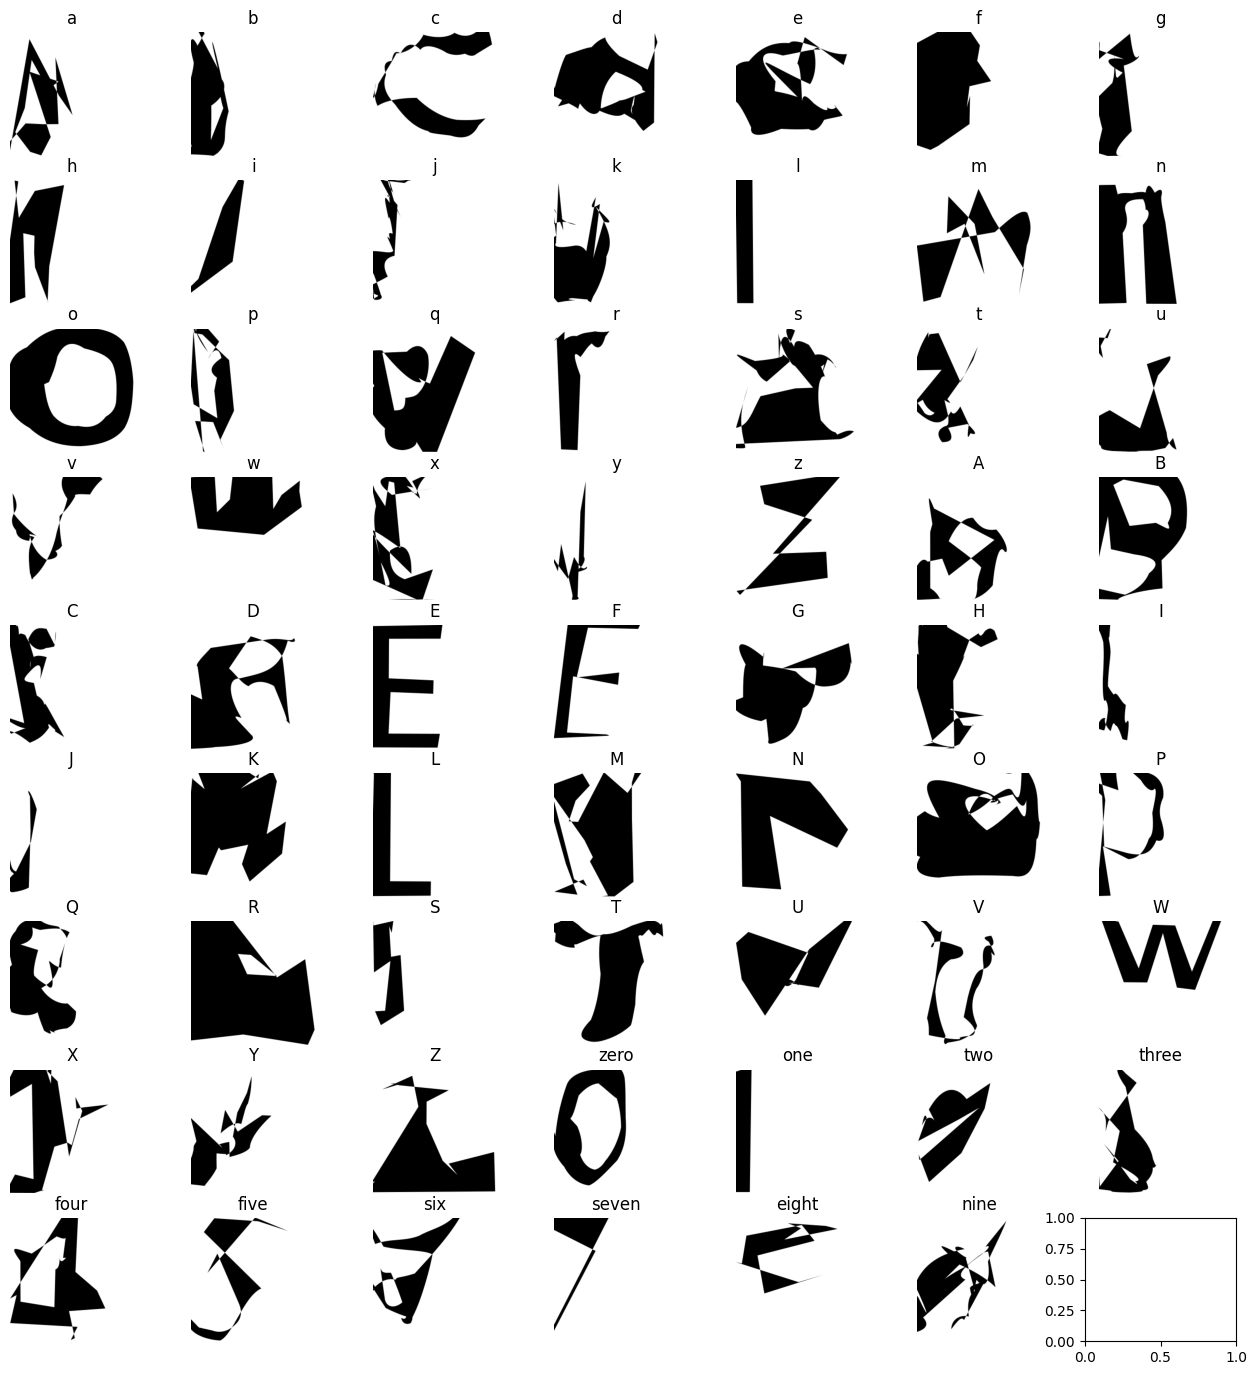

In [26]:
def gen_font():
    n = FONT_SIZE
    imgs = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device).repeat(n, 1, 1, 1)
    labels = dl.GLYPH_FILTER
    imgs, _ = sample(n, imgs, labels)
    imgs = to_numpy(decode_img(imgs.reshape(-1, IMG_SIZE*IMG_SIZE)))
    
    c_num = 7
    fig, axes = plt.subplots(
        math.ceil(n / c_num), c_num, 
        figsize=(math.ceil(n / c_num * 1.7), c_num * 5 // 2)
    )
    axes = axes.flatten()

    for j, (svg, label) in enumerate(zip(imgs, labels)):
        show_sampled(svg, axes[j])
        axes[j].title.set_text(label)
    plt.show()
    plt.close(fig)
    
gen_font()

## Интерполяция

  0%|▎                                                                                | 4/1000 [00:00<00:50, 19.63it/s]

|img1| = 203.63669
|img2| = 203.36539
|img1 - img2| = 295.98416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.21it/s]


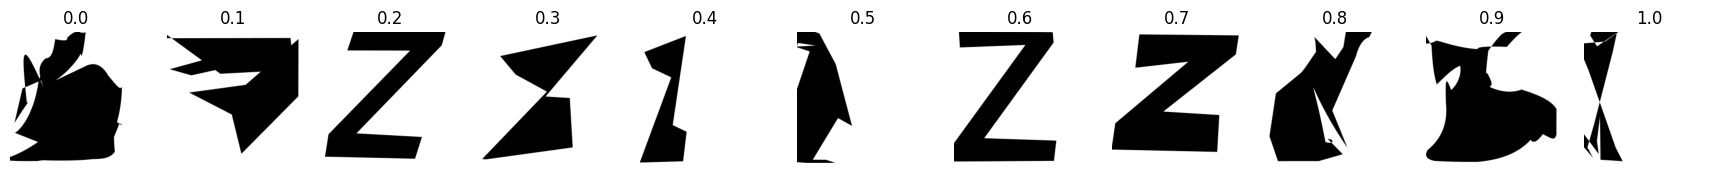

In [27]:
noise1 = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
noise2 = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
print('|img1| =', noise1.abs().sum().cpu().numpy())
print('|img2| =', noise2.abs().sum().cpu().numpy())
print('|img1 - img2| =', (noise1 - noise2).abs().sum().cpu().numpy())
n = 11
imgs = []
for i in range(n):
    cf = i / (n - 1)
    imgs.append(noise1 * (1 - cf) + noise2 * cf)

imgs = torch.cat(imgs, 0)

labels = ['z'] * n
imgs, _ = sample(n, imgs, labels)
imgs = to_numpy(decode_img(imgs.reshape(-1, IMG_SIZE*IMG_SIZE)))

fig, axes = plt.subplots(1, n, figsize=(n * 2, 3))
axes = axes.flatten()

for j, svg in enumerate(imgs):
    show_sampled(svg, axes[j])
    axes[j].title.set_text(str(j / (n - 1))[:4])
plt.show()
plt.close(fig)

## Проверка распределения

In [28]:
#!g1.4
sampled, sampled_labels = sample(1000)
sampled_imgs = to_numpy(decode_img(sampled.reshape(-1, IMG_SIZE*IMG_SIZE)))
for i, (img, lbl) in enumerate(zip(sampled_imgs, sampled_labels)):
    svg = SVG.decode(img)
    svg.mulsize(256)
    out_path = Path(f'imgs/samples3/{lbl}_{i}.png')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    svg2png(bytestring=svg.dump(), write_to=str(out_path))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:39<00:00,  1.93it/s]


In [29]:
#!g1.4
encoded_data = []
for images, _, _ in test_dataloader:
    images = encode_img(images.to(device))
    encoded_data.append(images)

encoded_data = to_numpy(torch.cat(encoded_data, 0))
print("Data shape", encoded_data.shape)
tsne_model = TSNE()
embedding = tsne_model.fit_transform(encoded_data)


AttributeError: 'list' object has no attribute 'to'

In [ ]:
#!g1.4
imgs = torch.randn((500, 1, IMG_SIZE, IMG_SIZE), device=device)
labels = np.random.choice(dl.GLYPH_FILTER, 500)
labels = labels2num(labels).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps, position=0, leave=True)):
    with torch.no_grad():
        residual = model(imgs, t, labels).sample

    imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    if (i + 1) % 100 == 0:
        sampled_embedding = tsne_model.fit_transform(to_numpy(imgs.view((sampled.shape[0], -1))))
        orig_embedding = tsne_model.fit_transform(encoded_data[:500])
        
        plt.figure(figsize=(8, 8))

        plt.scatter(
            orig_embedding[:500, 0], orig_embedding[:500, 1], 
            c='b',
            s=5,
            label='From AE',
        )

        plt.scatter(
            sampled_embedding[:, 0], sampled_embedding[:, 1], 
            c='g',
            s=5,
            label='From diffusion model',
        )

        plt.legend()
        plt.title(f'TSNE projection of the encoded glyphs, step {i+1}/1000');
        plt.show()

In [ ]:
#!g1.4
sampled, _ = sample(500)
sampled_embedding = tsne_model.fit_transform(to_numpy(sampled.view((sampled.shape[0], -1))))

In [ ]:
#!g1.4
plt.figure(figsize=(10, 10))


plt.scatter(
    embedding[:500, 0], embedding[:500, 1], 
    c='b',
    s=5,
    label='From AE',
)

plt.scatter(
    sampled_embedding[:, 0], sampled_embedding[:, 1], 
    c='g',
    s=5,
    label='From diffusion model',
)

plt.legend()
plt.title('TSNE projection of the encoded glyphs');
plt.show()